# Step II of Proposed Method :
* weakly supervised fine-tuning of the MLP trained at Step I 
* MIL training on the 279 cases (containing >250K tiles)
* MLP on top of ResNet50 features of each tile obtaining **prediction per tile**
* aggregating tile predictions under the naive assumption as **patient_prediction =  max(tiles_prediction)**
* trained using Adam optimizer with lr=0.001
* minimized weighted BCE loss with regard to class imbalance ratio 
* proposed a combined loss as a regularization strategy i.e imposing sparsity on the vector of local tile predictions:

**L = BCE(global_pred) + alpha * L1_norm(tiles_proba)/n_tiles**

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Step-II-of-Proposed-Method-:" data-toc-modified-id="Step-II-of-Proposed-Method-:-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Step II of Proposed Method :</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Parameters</a></span></li><li><span><a href="#Read-Data" data-toc-modified-id="Read-Data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Read Data</a></span></li><li><span><a href="#Data-Generator" data-toc-modified-id="Data-Generator-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Data Generator</a></span></li><li><span><a href="#Model" data-toc-modified-id="Model-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Model</a></span></li><li><span><a href="#Train" data-toc-modified-id="Train-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Train</a></span><ul class="toc-item"><li><span><a href="#Train-k-fold-CV-on-training-set" data-toc-modified-id="Train-k-fold-CV-on-training-set-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Train k-fold CV on training set</a></span></li><li><span><a href="#Plot-train-loss" data-toc-modified-id="Plot-train-loss-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Plot train loss</a></span></li><li><span><a href="#Retrain-ensemble-on-all-training-set" data-toc-modified-id="Retrain-ensemble-on-all-training-set-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Retrain ensemble on all training set</a></span></li></ul></li><li><span><a href="#Predict-test-set" data-toc-modified-id="Predict-test-set-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Predict test set</a></span></li></ul></div>

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import random
import re
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.utils import class_weight
import tensorflow as tf
import keras

print("keras version: ", keras.__version__)
print("tf version: ", tf.__version__)

from keras.layers import *
from keras.models import *
from keras import optimizers 


%matplotlib notebook

keras version:  2.3.1
tf version:  2.1.0


Using TensorFlow backend.


# Parameters

In [2]:
n_ensembles = 1
n_splits = 5
batch_size = 50
lr = 1e-3
epochs = 30

use_pre_trained_mlp = True
fc_layer_size = [100,10]
dropout_rate = 0.5

alpha = 0.0          # Loss = BCE(global_pred) + alpha * ||tiles_pred||1

# Read Data

In [3]:
#data_dir = Path('/media/diana/Shared/OWKIN_data_challenge')
data_dir = Path('../chowder_data')

train_dir = data_dir / "train_input" / "resnet_features"
test_dir = data_dir / "test_input"  / "resnet_features"

train_output_filename = data_dir / "train_output.csv"

df = pd.read_csv(train_output_filename)

# Get the filenames for train
#filenames_train = [train_dir / "{}.npy".format(idx) for idx in train_output["ID"]]
filenames_train = sorted(train_dir.glob("*.npy"))
for filename in filenames_train:
    assert filename.is_file(), filename

# Get the labels
labels_train = df["Target"].values

assert len(filenames_train) == len(labels_train)

In [4]:
df['Path'] = filenames_train

In [5]:
def get_number_tiles(filenames):
    n_tiles_per_image = []
    for f in filenames:
        patient_features = np.load(f)
        # Remove location features (but we could use them?)
        patient_features = patient_features[:, 3:]
        n_tiles_per_image.append(patient_features.shape[0])
    return n_tiles_per_image

df['tiles_count'] = get_number_tiles(filenames_train)

In [6]:
print(len(df))
df.head(10)

279


,ID,Target,Path,tiles_count
0,1,0,../chowder_data/train_input/resnet_features/ID...,1000
1,2,0,../chowder_data/train_input/resnet_features/ID...,1000
2,3,0,../chowder_data/train_input/resnet_features/ID...,1000
3,5,0,../chowder_data/train_input/resnet_features/ID...,839
4,6,0,../chowder_data/train_input/resnet_features/ID...,1000
5,7,0,../chowder_data/train_input/resnet_features/ID...,999
6,8,1,../chowder_data/train_input/resnet_features/ID...,1000
7,9,0,../chowder_data/train_input/resnet_features/ID...,1000
8,10,1,../chowder_data/train_input/resnet_features/ID...,442
9,11,0,../chowder_data/train_input/resnet_features/ID...,1000


# Data Generator

In [7]:
def batch_generator(df, batch_size, seed=None):
    '''
        randomized generator returing N = batch_size samples at a time
        (batch_size, max_tiles_per_batch, feature_size) e.g. (5, 1000, 2048)
        padding with zeros for constant n_tiles across samples        
    '''
    while True:
        # randomly sample N images
        df_batch = df.sample(n=batch_size, random_state=seed)
        # get labels
        Y = df_batch['Target'].values
        # compute the maximum number of tiles contained by a sample in batch
        n_tiles_per_batch = df_batch['tiles_count'].max()
        
        X = []
        for _, row in df_batch.iterrows(): 
            # get filenames
            filename = row['Path']
            # get features from file
            features = np.load(filename)[:, 3:]
            # get number of tiles in current samples
            n_tiles_per_image = features.shape[0]
            # pad with zeros if neccesary
            if n_tiles_per_image < n_tiles_per_batch:
                features = np.pad(features, ((n_tiles_per_batch-n_tiles_per_image, 0), (0, 0)))
            X.append(features)            
        X = np.stack(X, axis=0)
        yield X, Y

def test_batch_generator(df):
    '''
        generator returing one sample at a time
        (1, n_tiles_per_sample, n_features)
    '''
    n_batches = len(df)
    batch_id = 0

    while True:
        filename = df.iloc[batch_id]['Path']
        features = np.load(filename)[:, 3:]   
        batch_id = batch_id + 1 if batch_id < n_batches-1 else 0
        yield features[None,...]

# Model

In [8]:
def get_model():
    if use_pre_trained_mlp:
        # load pre trained MLP
        base_model = keras.models.load_model("base_model.h5")
    else:
        # build MLP
        tile = Input((2048,))
        x = tile
        for fc in fc_layer_size:
            x = Dense(fc, activation='sigmoid')(x)
            if dropout_rate > 0:
                x = Dropout(dropout_rate)(x)
        tile_prediction = Dense(1, activation='sigmoid')(x)
        base_model = Model(inputs=tile, outputs=tile_prediction)
    
    input = Input(shape=(None, 2048))
    local_predictions = TimeDistributed(base_model)(input)

    global_prediction = GlobalMaxPool1D()(local_predictions)
    model = Model(inputs=input, outputs=global_prediction)
    
    def my_loss_fn(y_true, y_pred):
        local_predictions_l1 = tf.reduce_sum(local_predictions) / tf.cast(tf.size(local_predictions), tf.float32)
        bce = keras.losses.binary_crossentropy(y_true, y_pred)
        return (bce + alpha * local_predictions_l1)

    model.compile(optimizers.Adam(lr),
                  loss=my_loss_fn, #'binary_crossentropy',
                  metrics=[tf.keras.metrics.AUC()])
    return model

In [9]:
model = get_model()
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, 2048)        0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 1)           206941    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 1)                 0         
Total params: 206,941
Trainable params: 206,941
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


# Train

## Train k-fold CV on training set

In [10]:
%%time

class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(df.Target.values), y=df.Target.values)
print("class weights", class_weights)

kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1)

history_folds = []
aucs = []

for fold, (i_train, i_val) in enumerate(kf.split(df, df.Target)):
    
    print("Fold", fold)
    
    # get data

    df_train = df.iloc[i_train]
    df_val = df.iloc[i_val]
    
    train_generator = batch_generator(df_train, batch_size)
    val_generator = batch_generator(df_val, 1)
    
    train_steps = int(np.ceil(len(df_train)/batch_size))
    val_steps = len(df_val)
    
    # build model
    model = get_model()
    
    # train model
    history = model.fit(
                            train_generator,
                            steps_per_epoch=train_steps,
                            validation_data=val_generator,
                            validation_steps=val_steps,
                            epochs=epochs,
                            verbose=0,
                            class_weight=dict(enumerate(class_weights)))
    
    auc = model.evaluate(val_generator, steps=val_steps)[-1]
    print("Val AUC = {:.3f}".format(auc))
    aucs.append(auc)
    history_folds.append(history.history)
    
aucs = np.array(aucs)
print("Val AUC: mean {:.3f}, std {:.3f}".format(aucs.mean(), aucs.std()))

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


class weights [0.83532934 1.24553571]
Fold 0
56/56 [==============================] - 1s 23ms/step
Val AUC = 0.933
Fold 1


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


56/56 [==============================] - 1s 22ms/step
Val AUC = 0.937
Fold 2


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


56/56 [==============================] - 1s 23ms/step
Val AUC = 0.920
Fold 3


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


56/56 [==============================] - 1s 22ms/step
Val AUC = 0.922
Fold 4


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


55/55 [==============================] - 1s 23ms/step
Val AUC = 0.920
Val AUC: mean 0.926, std 0.007
CPU times: user 5min 41s, sys: 7min 3s, total: 12min 44s
Wall time: 12min 47s


## Plot train loss

<IPython.core.display.Javascript object>


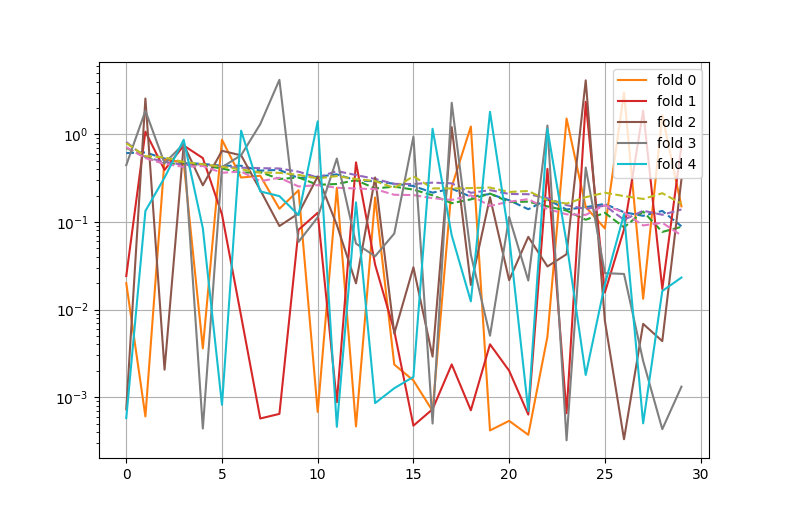

In [18]:
plt.figure()
for fold in range(len(history_folds)):
    plt.plot(history_folds[fold]['loss'], '--')
    plt.plot(history_folds[fold]['val_loss'], label='fold {}'.format(fold))
plt.yscale('log')
plt.legend()
plt.grid('on')

## Retrain ensemble on all training set

In [12]:
%%time
ensemble_models = []

for e in range(n_ensembles):
    print("Ensemble", e)
    generator = batch_generator(df, batch_size)
    steps = int(np.ceil(len(df)/batch_size))
    model = get_model()
    model.fit(generator,
              steps_per_epoch=steps,
              epochs=epochs,
              verbose=0,
              class_weight=dict(enumerate(class_weights)))
    ensemble_models.append(model)

Ensemble 0


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


CPU times: user 1min 2s, sys: 1min 31s, total: 2min 34s
Wall time: 2min 34s


# Predict test set

In [13]:
# get filenames of test set samples
filenames_test = sorted(test_dir.glob("*.npy"))
for filename in filenames_test:
    assert filename.is_file(), filename
# extract image IDs from filenames
ids = [re.search("ID_(.+?).npy", str(filename)).group(1) for filename in filenames_test]
# populate DF with IDs
df_test = pd.DataFrame({'ID':ids, 'Path': filenames_test })
df_test.head(10)

,ID,Path
0,000,../chowder_data/test_input/resnet_features/ID_...
1,004,../chowder_data/test_input/resnet_features/ID_...
2,016,../chowder_data/test_input/resnet_features/ID_...
3,017,../chowder_data/test_input/resnet_features/ID_...
4,020,../chowder_data/test_input/resnet_features/ID_...
5,023,../chowder_data/test_input/resnet_features/ID_...
6,028,../chowder_data/test_input/resnet_features/ID_...
7,030,../chowder_data/test_input/resnet_features/ID_...
8,031,../chowder_data/test_input/resnet_features/ID_...
9,032,../chowder_data/test_input/resnet_features/ID_...


In [14]:
# get predictions of all trained models in the ensemble
ensemble_prediction = []
for model in ensemble_models:
    # initialize data generator and compute number of steps
    test_generator = test_batch_generator(df_test)
    test_steps = len(df_test)
    # predict
    ensemble_prediction.append(model.predict(test_generator, steps=test_steps))
ensemble_prediction = np.stack(ensemble_prediction, axis=0)
print(ensemble_prediction.shape)

(1, 120, 1)


In [15]:
# get final prediction as the average vote between ensembles
# and populate DF with the predictions
df_test['Target'] = ensemble_prediction.mean(axis=0)
# clean DF and save
df_test.set_index("ID", inplace=True)
df_test = df_test.drop(columns=['Path'])
df_test.to_csv(data_dir / "preds_test_maxpool_pretrained={}.csv".format(use_pre_trained_mlp))
df_test.head(10)

,Target
ID,
000,0.098913
004,0.056371
016,0.999741
017,0.999790
020,0.515873
023,0.052089
028,0.001978
030,0.005987
031,0.999775


<IPython.core.display.Javascript object>


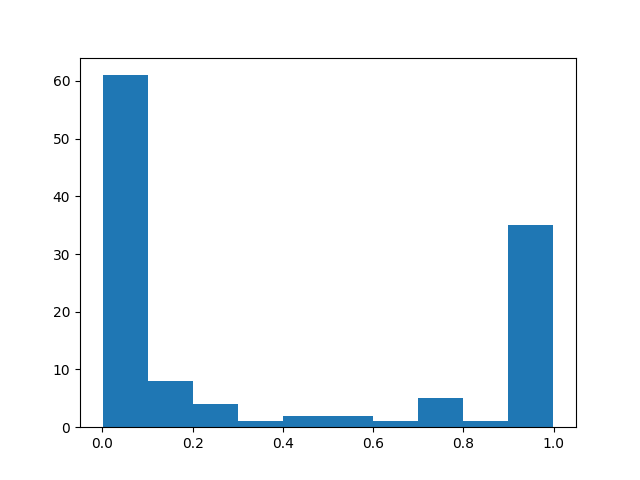

In [16]:
# plot label ditribution (sanity check: expected bimodal distribution)
plt.figure()
_ = plt.hist(df_test['Target'])